In [48]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터 불러오기
df = pd.read_csv("Mall_Customers.csv")
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [49]:
# 1. CustomerID 제거
df = df.drop(columns=['CustomerID'])  # CustomerID는 군집화에 필요 없는 고유 ID이므로 제거

# 2. Gender 인코딩 (LabelEncoder 사용)
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# 3. Age, Annual Income, Spending Score 표준화
scaler_standard = StandardScaler()
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler_standard.fit_transform(
    df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
)
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,-1.424569,-1.738999,-0.434801
1,1,-1.281035,-1.738999,1.195704
2,0,-1.352802,-1.700830,-1.715913
3,0,-1.137502,-1.700830,1.040418
4,0,-0.563369,-1.662660,-0.395980
...,...,...,...,...
195,0,-0.276302,2.268791,1.118061
196,0,0.441365,2.497807,-0.861839
197,1,-0.491602,2.497807,0.923953
198,1,-0.491602,2.917671,-1.250054


c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_

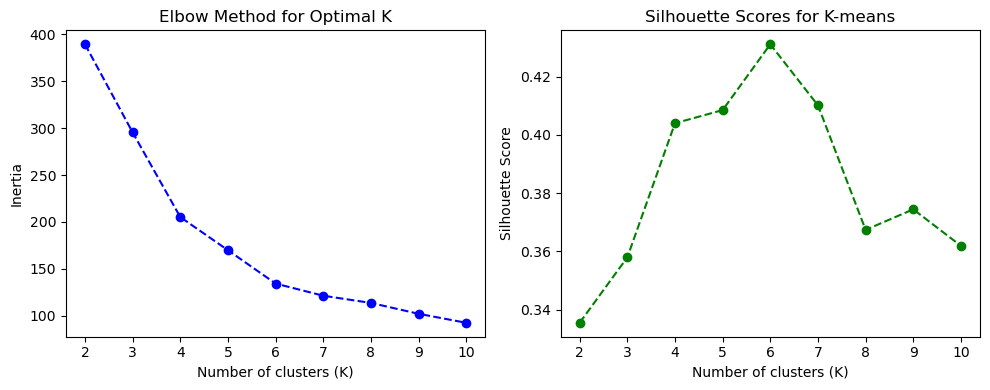

Optimal number of clusters (K) for K-means: 6


c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


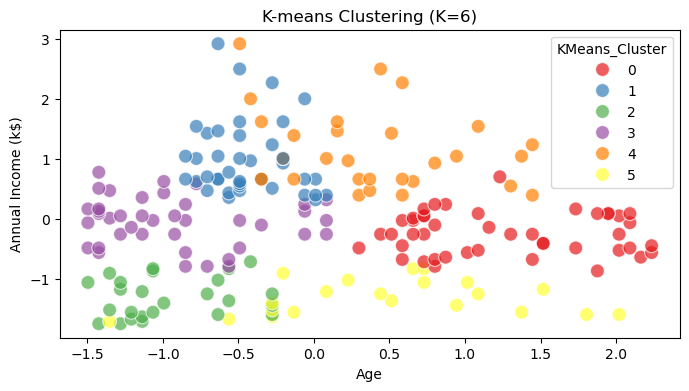

In [50]:
# K-means 군집화
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # K 값은 2부터 10까지 확인

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
    inertia.append(kmeans.inertia_)
    score = silhouette_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], kmeans.labels_)
    silhouette_scores.append(score)

# K 값 선택 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# 엘보우 기법
ax[0].plot(k_range, inertia, marker='o', color='b', linestyle='--')
ax[0].set_title('Elbow Method for Optimal K')
ax[0].set_xlabel('Number of clusters (K)')
ax[0].set_ylabel('Inertia')

# 실루엣 점수 시각화
ax[1].plot(k_range, silhouette_scores, marker='o', color='g', linestyle='--')
ax[1].set_title('Silhouette Scores for K-means')
ax[1].set_xlabel('Number of clusters (K)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# 최적의 K 값 선택
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (K) for K-means: {optimal_k}")

# 최적의 K 값으로 K-means 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# K-means 결과 시각화
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df['Age'], y=df['Annual Income (k$)'], hue=df['KMeans_Cluster'], palette='Set1', s=100, alpha=0.7)
plt.title(f'K-means Clustering (K={optimal_k})')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show()

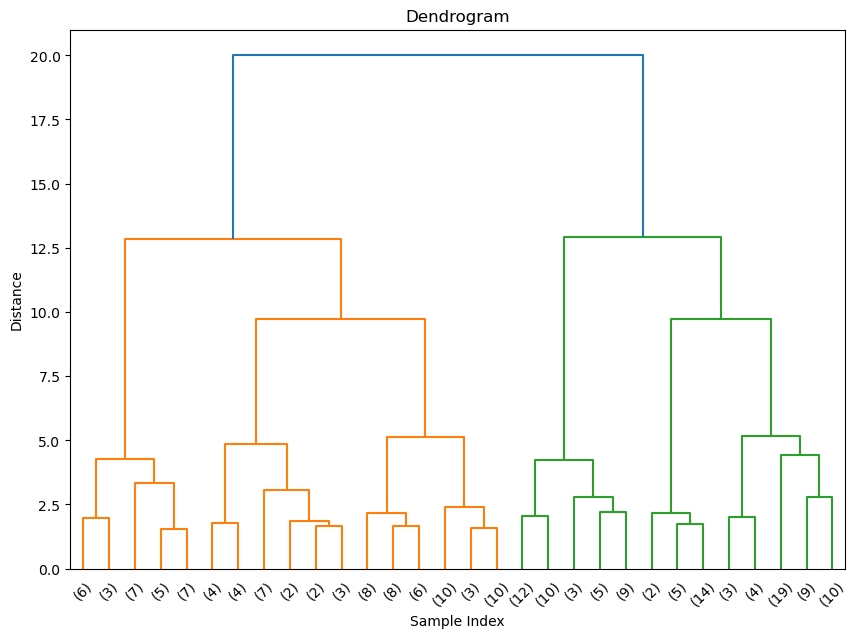

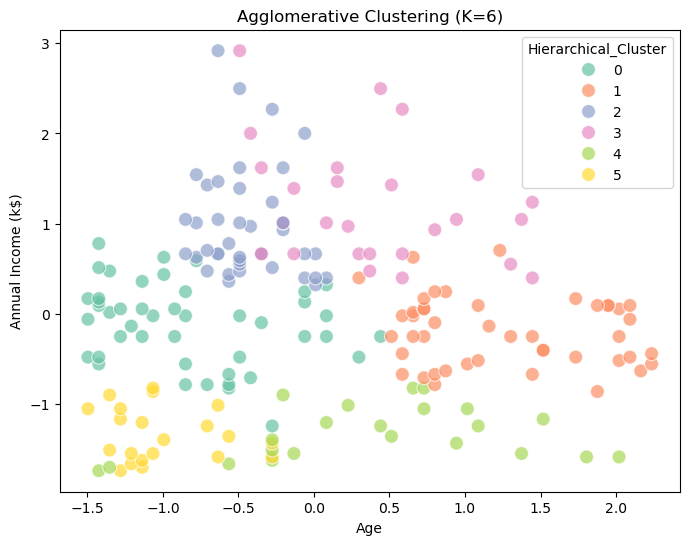

In [51]:
# 계층적 군집화 (덴드로그램)
linked = linkage(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=30)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
df['Hierarchical_Cluster'] = agg_clust.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# 계층적 군집화 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Annual Income (k$)'], hue=df['Hierarchical_Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title(f'Agglomerative Clustering (K={optimal_k})')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show()

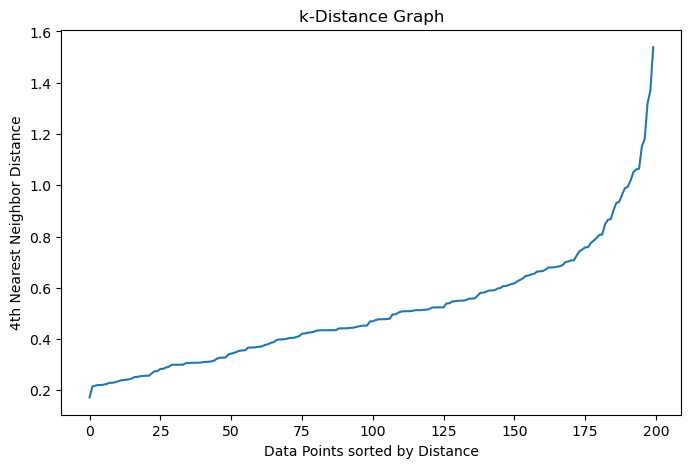

eps=0.1, 클러스터 수: 1, 잡음(-1) 수: 200
eps=0.2, 클러스터 수: 2, 잡음(-1) 수: 195
eps=0.5, 클러스터 수: 7, 잡음(-1) 수: 60
eps=0.75, 클러스터 수: 2, 잡음(-1) 수: 10
eps=1.0, 클러스터 수: 2, 잡음(-1) 수: 2


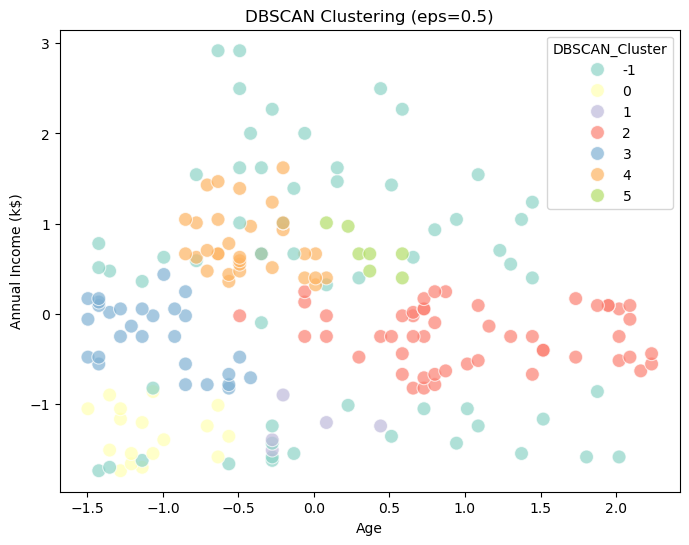

In [57]:
# db- scan
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# 데이터 정규화 (Standardization)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# k-거리 그래프를 통해 eps 값 찾기
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# 4번째 이웃의 거리 (k-거리 그래프)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Data Points sorted by Distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()

# 여러 eps 값으로 DBSCAN 클러스터링 수행
eps_values = [0.1, 0.2, 0.5, 0.75, 1.0]  # 여러 eps 값을 시도
best_dbscan = None
best_eps = 0
best_cluster_count = 0

for eps_value in eps_values:
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)
    
    # 클러스터 수와 잡음(-1) 수 확인
    cluster_count = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
    print(f"eps={eps_value}, 클러스터 수: {cluster_count}, 잡음(-1) 수: {sum(df['DBSCAN_Cluster'] == -1)}")
    
    # 가장 좋은 클러스터 수를 선택
    if cluster_count > best_cluster_count:
        best_dbscan = dbscan
        best_eps = eps_value
        best_cluster_count = cluster_count

# 최적의 eps 값으로 DBSCAN 결과 시각화
df['DBSCAN_Cluster'] = best_dbscan.fit_predict(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Annual Income (k$)'], hue=df['DBSCAN_Cluster'], palette='Set3', s=100, alpha=0.7)
plt.title(f'DBSCAN Clustering (eps={best_eps})')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show()

<Figure size 1200x800 with 0 Axes>

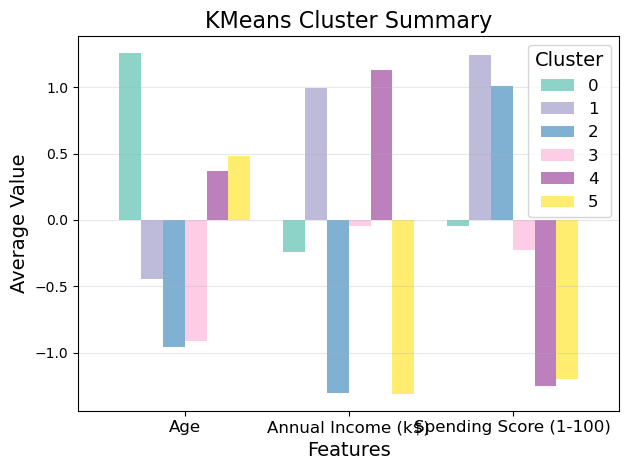

<Figure size 1200x800 with 0 Axes>

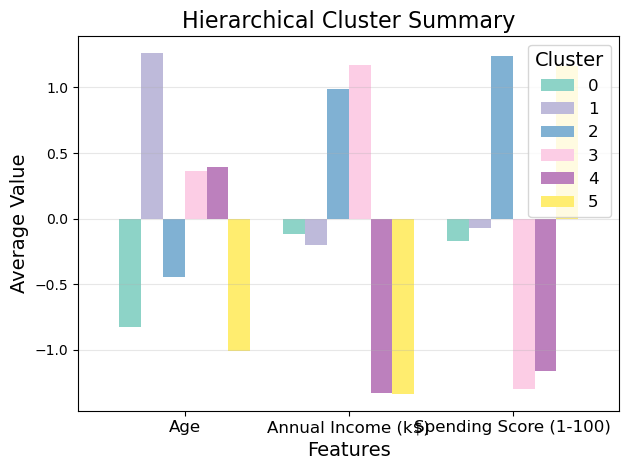

<Figure size 1200x800 with 0 Axes>

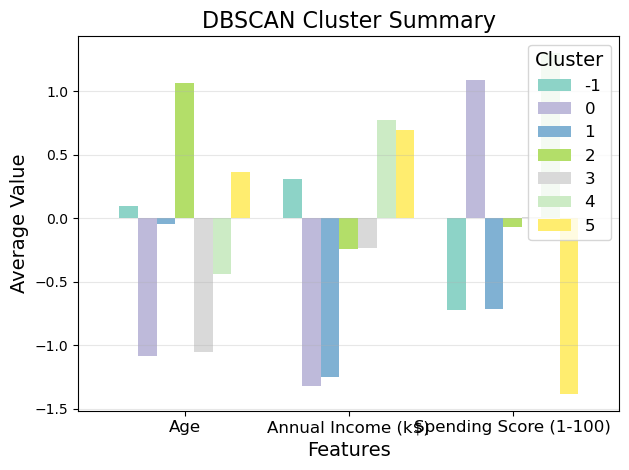

In [64]:
# 3개 모델 비교 
import matplotlib.pyplot as plt

# 각 클러스터별 평균값 계산
cluster_summary_kmeans = df.groupby('KMeans_Cluster')[numeric_columns].mean()
cluster_summary_hierarchical = df.groupby('Hierarchical_Cluster')[numeric_columns].mean()
cluster_summary_dbscan = df.groupby('DBSCAN_Cluster')[numeric_columns].mean()

# KMeans 클러스터 요약 시각화
plt.figure(figsize=(12, 8))
cluster_summary_kmeans.T.plot(kind='bar', colormap='Set3', width=0.8)
plt.title('KMeans Cluster Summary', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Hierarchical 클러스터 요약 시각화
plt.figure(figsize=(12, 8))
cluster_summary_hierarchical.T.plot(kind='bar', colormap='Set3', width=0.8)
plt.title('Hierarchical Cluster Summary', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# DBSCAN 클러스터 요약 시각화
plt.figure(figsize=(12, 8))
cluster_summary_dbscan.T.plot(kind='bar', colormap='Set3', width=0.8)
plt.title('DBSCAN Cluster Summary', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average Value', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
# 3개 모델 비교 Silhouette Score, Davies-Bouldin Index
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 각 클러스터링 방법의 결과 가져오기
kmeans_clusters = df['KMeans_Cluster']
hierarchical_clusters = df['Hierarchical_Cluster']
dbscan_clusters = df['DBSCAN_Cluster']

# DBSCAN에서 -1은 잡음이므로, -1을 제외하고 평가합니다.
dbscan_filtered = df[df['DBSCAN_Cluster'] != -1]

# DBSCAN 클러스터링 결과에서 -1을 제외한 후 클러스터링
dbscan_clusters_filtered = dbscan_filtered['DBSCAN_Cluster']

# Silhouette Score 계산 (클러스터 개수가 일정해야 함)
kmeans_silhouette = silhouette_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], kmeans_clusters)
hierarchical_silhouette = silhouette_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], hierarchical_clusters)
dbscan_silhouette = silhouette_score(dbscan_filtered[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], dbscan_clusters_filtered)

# Davies-Bouldin Index 계산
kmeans_davies_bouldin = davies_bouldin_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], kmeans_clusters)
hierarchical_davies_bouldin = davies_bouldin_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], hierarchical_clusters)
dbscan_davies_bouldin = davies_bouldin_score(dbscan_filtered[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], dbscan_clusters_filtered)

# 결과 출력
print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
print("---------------------------------------------------")
print(f"KMeans Davies-Bouldin Index: {kmeans_davies_bouldin:.4f}")
print(f"Hierarchical Davies-Bouldin Index: {hierarchical_davies_bouldin:.4f}")
print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin:.4f}")


KMeans Silhouette Score: 0.4311
Hierarchical Silhouette Score: 0.4201
DBSCAN Silhouette Score: 0.4817
---------------------------------------------------
KMeans Davies-Bouldin Index: 0.8350
Hierarchical Davies-Bouldin Index: 0.8521
DBSCAN Davies-Bouldin Index: 0.6386


In [67]:
# 고객 행동 예측 모델 구축(분류 모델)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 특징 변수와 목표 변수 설정
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]  # 특징 변수
y = df['KMeans_Cluster']  # 목표 변수 (클러스터 레이블)

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 분류 모델 구축
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         6
           3       0.92      0.92      0.92        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00         5

    accuracy                           0.97        60
   macro avg       0.97      0.98      0.97        60
weighted avg       0.97      0.97      0.97        60



c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_

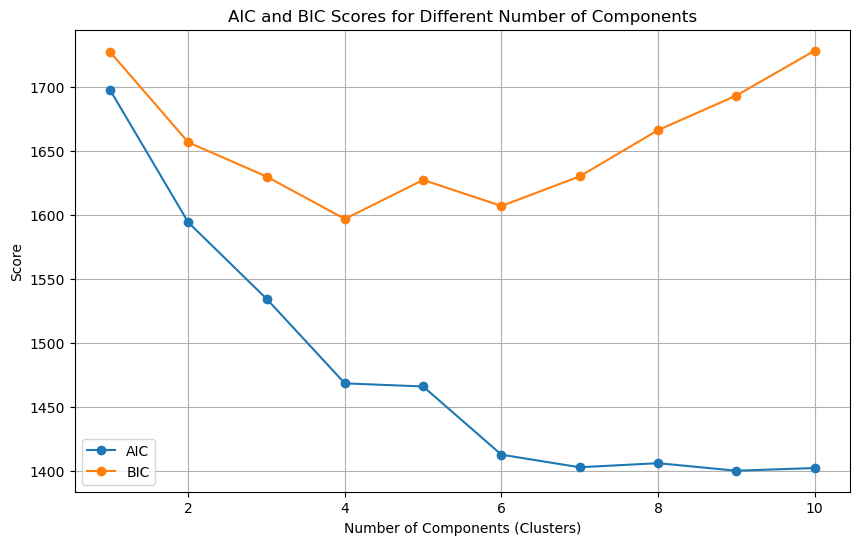

In [72]:
# AIC/BIC 계산을 통해 최적의 n_components 찾기
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# AIC/BIC 계산을 통해 최적의 n_components 찾기
aic_scores = []
bic_scores = []

# 클러스터 수를 1부터 10까지 시도
for n in range(1, 11):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
    aic_scores.append(gmm.aic(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]))
    bic_scores.append(gmm.bic(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]))

# AIC/BIC 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), aic_scores, label='AIC', marker='o')
plt.plot(range(1, 11), bic_scores, label='BIC', marker='o')
plt.title('AIC and BIC Scores for Different Number of Components')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\qorau\anaconda3\envs\deeplearingVM\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


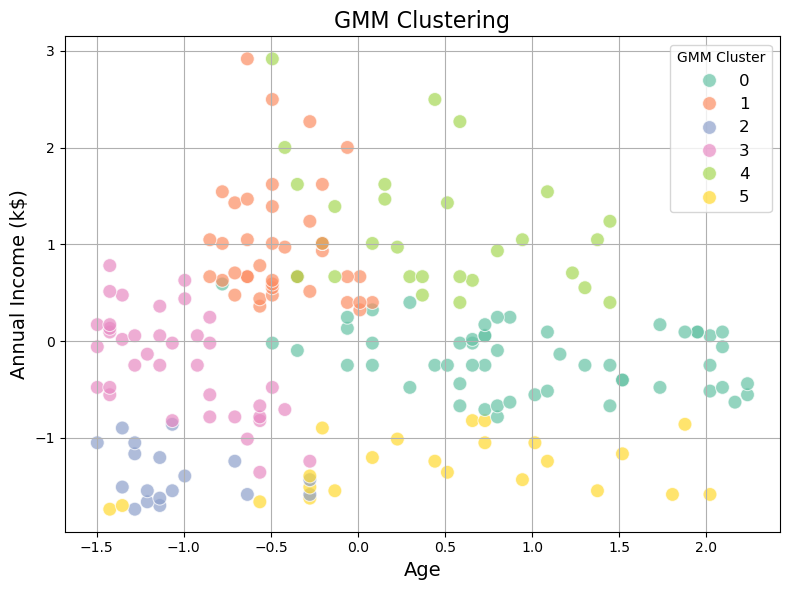

In [ ]:
#GMM 학습
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# GMM 모델로 클러스터링 수행
gmm = GaussianMixture(n_components=6, random_state=42)  # n_components는 클러스터 개수
df['GMM_Cluster'] = gmm.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# GMM 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Annual Income (k$)'], hue=df['GMM_Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title('GMM Clustering', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Annual Income (k$)', fontsize=14)
plt.legend(title='GMM Cluster', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
# GMM 클러스터의 실루엣 점수 계산
gmm_silhouette = silhouette_score(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], df['GMM_Cluster'])
print(f'GMM Silhouette Score: {gmm_silhouette}')

GMM Silhouette Score: 0.3999977925024676
